<a href="https://colab.research.google.com/github/schmelto/machine-learning/blob/main/Deeplearning/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation
## Imports and Version Selection


In [ ]:
# TensorFlow ≥2.0 is required for this notebook
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# check if GPU is available as this notebook will be very slow without GPU
if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# jupyters magic command
%matplotlib inline

In [ ]:
import typing

def plot_learning_curve(
    title: str, x: int, y: int, y_test: int, ylim: float = 0.6
) -> None:
    plt.figure()
    plt.title(title)
    axes = plt.gca()
    axes.set_ylim([ylim, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    train_sizes = x
    train_scores = y
    test_scores = y_test

    plt.grid()

    plt.plot(
        train_sizes,
        train_scores,
        "o-",
        color=(177 / 255, 6 / 255, 58 / 255),
        label="Training accuracy",
    )
    plt.plot(
        train_sizes,
        test_scores,
        "o-",
        color=(246 / 255, 168 / 255, 0),
        label="Validation accuracy",
    )

    plt.legend(loc="best")
    
def plot_history(title: str, history: "History", ylim: float = 0.6) -> None:
    y = history.history["accuracy"]
    y_test = history.history["val_accuracy"]
    plot_learning_curve(title, np.arange(1, 1 + len(y)), y, y_test, ylim)

def plot_images(images: "DatasetV1Adapter", class_names: typing.List[str]) -> None:
    plt.figure(figsize=(12, 10))
    index = 0
    for image, label in images:
        index += 1
        plt.subplot(3, 3, index)
        plt.imshow(image)
        plt.title("Class: {}".format(class_names[label]))
        plt.axis("off")

def dataset_to_ndarray(
    train_data: "DatasetV1Adapter", test_data: "DatasetV1Adapter"
) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # convert tf.Dataset in np.ndarray, because ImageDataGenerators for
    # data augmentation don't work with tf.Datasets
    preprocessed_train_data = train_data.map(preprocess).batch(2950)
    preprocessed_test_data = test_data.map(preprocess).batch(720)

    x = np.array([])
    y = np.array([])
    for elem in preprocessed_train_data:
        x = np.append(x, elem[0].numpy())
        y = np.append(y, elem[1].numpy())

    x_test = np.array([])
    y_test = np.array([])
    for elem in preprocessed_test_data:
        x_test = np.append(x_test, elem[0].numpy())
        y_test = np.append(y_test, elem[1].numpy())

    # X was flat before
    x = x.reshape(len(x) // (224 * 224 * 3), 224, 224, 3)
    x_test = x_test.reshape(len(x_test) // (224 * 224 * 3), 224, 224, 3)
    return x, y, x_test, y_test

def plot_images_with_labels(
    images: typing.List[int], labels: np.ndarray, class_names: typing.List[str]
) -> None:
    if len(images) != 9:
        images = images[:9]
        labels = labels[:9]
    labels = labels.astype("int")

    plt.figure(figsize=(12, 10))
    index = 0
    for image, label in zip(images, labels):
        index += 1
        plt.subplot(3, 3, index)
        plt.imshow(image)
        plt.title("Class: {}".format(class_names[label]))
        plt.axis("off")

In [ ]:
# resize the images to a uniform size
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

## Loading and Preprocessing

In [ ]:
# download the dataset with labels and with information about the data
data, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

# print the most important information
dataset_size = info.splits['train'].num_examples
print('dataset size: ', dataset_size)
class_names = info.features['label'].names
print('class names: ', class_names)
n_classes = info.features['label'].num_classes
print('number of classes: ', n_classes)

batch_size = 32

try:
  train_data = tfds.load('tf_flowers', split="train[:80%]", as_supervised=True)
  test_data = tfds.load('tf_flowers', split="train[80%:100%]", as_supervised=True)
  train_data = train_data.shuffle(1000)
  test_data = test_data
except(Exception):
  # split the data into train and test data with a 8:2 ratio
  train_split, test_split = tfds.Split.TRAIN.subsplit([8, 2])
  train_data = tfds.load('tf_flowers', split=train_split, as_supervised=True)
  test_data = tfds.load('tf_flowers', split=test_split, as_supervised=True)
  train_data = train_data.shuffle(1000)
  test_data = test_data
  
# convert tf.dataset to numpy array
X, y, X_test, y_test = dataset_to_ndarray(train_data, test_data)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
dataset size:  3670
class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
number of classes:  5


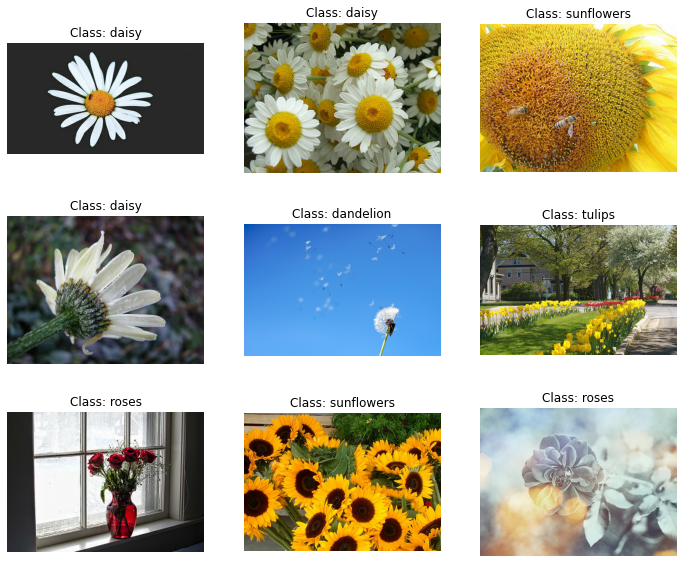

In [ ]:
# show some images from the dataset
plot_images(train_data.take(9).map(lambda x, y: (x / 255, y)), class_names)

## Definition and Training

In [ ]:
# returns a standard CNN with provided or default parameters
def make_model(
  learning_rate=0.0001,
  momentum=0.9,
  decay=0.002,
  dense_neurons=1000,
  n_filters=32,
  first_kernel_size=(7,7),
  activation='elu',
  noise=False
):

  # Images must have 224x224 px and RGB color
  input_layer = Input(shape=(224, 224, 3))
  input = input_layer

  # Include noise as data augmentation technique
  if noise:
    input = GaussianNoise(0.1)(input_layer)

  # Convolutional Neural Network
  # It consists of 5 stacked Convolutional Layers with Max Pooling
  model = Conv2D(
      filters=n_filters, 
      kernel_size=(7,7), 
      activation=activation
      )(input)
  model = MaxPooling2D((2,2))(model)

  for i in range(2, 5):
    model = Conv2D(
        filters = i * n_filters, 
        kernel_size=(3,3), 
        activation=activation
      )(model)
    model = MaxPooling2D((2,2))(model)

  model = Conv2D(filters = 5 * n_filters, 
    kernel_size=(3,3), 
    activation=activation, 
    padding='same'
  )(model)
  model = MaxPooling2D((2,2))(model)

  # Fully-Connected-Classifier
  model = Flatten()(model)
  model = Dense(dense_neurons, activation=activation)(model)

  model = Dense(dense_neurons / 2, activation=activation)(model)

  # Output Layer
  output = Dense(n_classes, activation="softmax")(model)

  CNN_model = Model(input_layer, output)

  # Compile model
  optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum) #, decay=decay)
  CNN_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
  
  return CNN_model


In [ ]:
make_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 218, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 51, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 96)        0     

In [ ]:
# Define an image generator which only rescales pictures
generator = tf.keras.preprocessing.image.ImageDataGenerator()
# generate iterator over generated images from existing images
train_iterator = generator.flow(X, y)
test_iterator = generator.flow(X_test, y_test)

In [ ]:
# train the model without data augmentation
CNN_model = make_model()
history = CNN_model.fit(
    train_iterator,
    steps_per_epoch=92,
    epochs=40,
    validation_data=test_iterator,
    validation_steps=23
)

Epoch 1/40
92/92 [==============================] - 11s 46ms/step - loss: 5.1614 - accuracy: 0.3062 - val_loss: 1.1728 - val_accuracy: 0.5095
Epoch 2/40
92/92 [==============================] - 4s 40ms/step - loss: 1.1615 - accuracy: 0.5321 - val_loss: 1.1556 - val_accuracy: 0.5490
Epoch 3/40
92/92 [==============================] - 4s 41ms/step - loss: 1.0108 - accuracy: 0.6052 - val_loss: 1.0928 - val_accuracy: 0.5545
Epoch 4/40
92/92 [==============================] - 4s 41ms/step - loss: 0.9409 - accuracy: 0.6317 - val_loss: 0.9831 - val_accuracy: 0.6022
Epoch 5/40
92/92 [==============================] - 4s 41ms/step - loss: 0.8100 - accuracy: 0.6831 - val_loss: 0.9415 - val_accuracy: 0.6294
Epoch 6/40
92/92 [==============================] - 4s 41ms/step - loss: 0.7638 - accuracy: 0.7125 - val_loss: 1.0550 - val_accuracy: 0.5886
Epoch 7/40
92/92 [==============================] - 4s 40ms/step - loss: 0.7714 - accuracy: 0.7157 - val_loss: 0.9306 - val_accuracy: 0.6362
Epoch 8/40
9

In [ ]:
# Create an image generator with different data augmentation techniques
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    # vertical_flip=True
)

# generate an image iterator over augmented images from the training data
train_iterator = generator.flow(X, y)

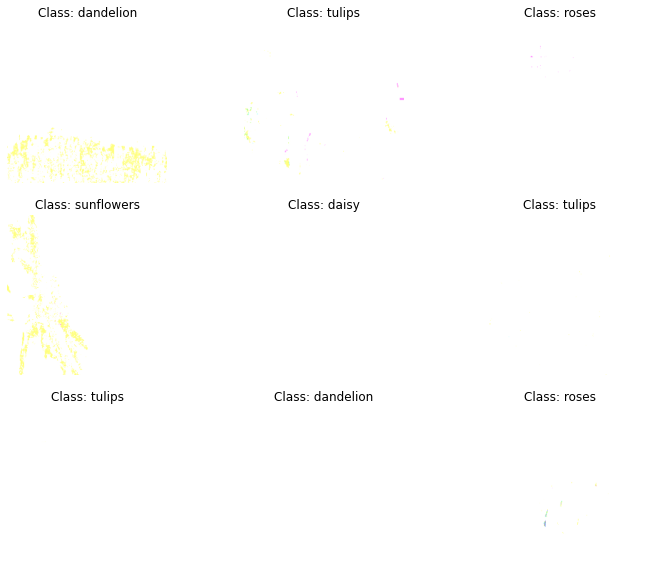

In [ ]:
# plot some augmented images
X_augmented, y_augmented = next(train_iterator)
plot_images_with_labels((X_augmented + 1) / 2, y_augmented, class_names)

In [ ]:
# train a model with data augmentation and noise
data_augmentation_model = make_model(learning_rate=0.001, noise=True)
history_data_augmentation = data_augmentation_model.fit(
    train_iterator,
    steps_per_epoch=92,
    epochs=40,
    validation_data=test_iterator,
    validation_steps=23
)

Epoch 1/40
92/92 [==============================] - 27s 292ms/step - loss: 5.2322 - accuracy: 0.1956 - val_loss: 1.6586 - val_accuracy: 0.1907
Epoch 2/40
92/92 [==============================] - 27s 292ms/step - loss: 1.7429 - accuracy: 0.2026 - val_loss: 1.7311 - val_accuracy: 0.1921
Epoch 3/40
92/92 [==============================] - 27s 293ms/step - loss: 1.7208 - accuracy: 0.2148 - val_loss: 1.6012 - val_accuracy: 0.2166
Epoch 4/40
92/92 [==============================] - 27s 294ms/step - loss: 1.6196 - accuracy: 0.2397 - val_loss: 1.4946 - val_accuracy: 0.3283
Epoch 5/40
92/92 [==============================] - 27s 293ms/step - loss: 1.4452 - accuracy: 0.3825 - val_loss: 1.3043 - val_accuracy: 0.4918
Epoch 6/40
92/92 [==============================] - 27s 296ms/step - loss: 1.2258 - accuracy: 0.4968 - val_loss: 1.2243 - val_accuracy: 0.4837
Epoch 7/40
92/92 [==============================] - 27s 296ms/step - loss: 1.2060 - accuracy: 0.5109 - val_loss: 1.1546 - val_accuracy: 0.4959

## Visualization and Evaluation

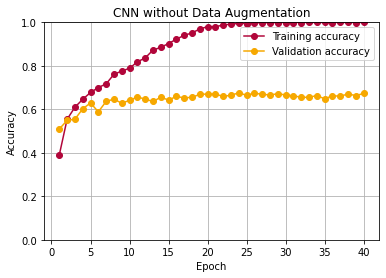

In [ ]:
plot_history('CNN without Data Augmentation', history, 0)

# validation accuracy might be sometimes higher than training accuracy due to 2 reasons:
#     - train acc is calculated as the mean of the whole epoch, test acc is calculated after each epoch
#       (where the model is better than in the mid of the epoch)
#     - when you use e.g. Dropout or aggressive data augmentation, the behavior at training time is different 

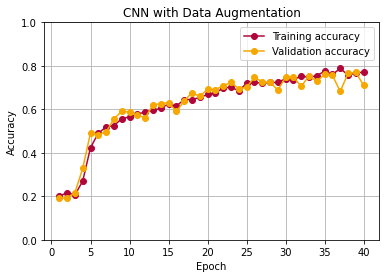

In [ ]:
plot_history('CNN with Data Augmentation', history_data_augmentation, 0)